## Carga de librerias

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import log
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection

print("Current working directory:", os.getcwd())

Current working directory: /Users/jenriquezafra/Proyectos/Dev/python/TFG


#  Modelo determinista
Vamos a implementar Lotka-Volterra para $N=4$ especies. Usaremos la expresión
$$
\frac{dx_i}{dt} = r_ix_i\left( 1- \sum_{j=1}^N a_{ij}x_j \right)
$$

In [2]:
# cargamos la función
from src.det_system import DeterministicSystem

# Definimos los parámetros del sistema
r = np.array(
    [1, 0.72, 1.53, 1.27]
)

a = np.array([
    [1, 1.09, 1.52, 0],
    [0, 1, 0.44, 1.36],
    [2.33, 0, 1, 0.47],
    [1.21, 0.51, 0.35, 1]
])

x0 = np.array([0.5, 0.5, 0.5, 0.5])

## 1. Análisis dinámico
Estudiamos sus puntos de equilibrio y su estabilidad.

Los puntos de equilibrio no triviales cumplen 
$$
1-\sum_{j=1}^N a_{ij}x_j^* = 0 \iff A\vec{x^*} = \vec{1} \Longrightarrow \vec{x^*} = A^{-1}\vec{1},
$$
donde $\vec{1}$ es un vector columna de solo unos.


In [3]:
# primero hallamos los puntos de equilibrio:
vec1 = np.array([1,1,1,1]).reshape(-1, 1)
a_inv = np.linalg.inv(a)

x_eq = a_inv @ vec1

print('Los puntos de equilibrio son:', x_eq.round(3))

Los puntos de equilibrio son: [[0.301]
 [0.459]
 [0.131]
 [0.356]]


Si aplicamos los puntos de equilibrio anteriores al Jacobiano, tenemos 
$$
J^*_{ij} = -r_ix_i^* a_{ij}.
$$
Para que estos puntos sean de equilibrio (atractores), los autovalores $\lambda$ del Jacobiano deben cumplir
$$
\Re(\lambda)< 0.
$$


In [4]:
J_eq = -r * x_eq * a

print(J_eq)

[[-0.301303   -0.23646259 -0.70071025 -0.        ]
 [-0.         -0.33023131 -0.30876627 -0.79218822]
 [-0.30468351 -0.         -0.20007115 -0.0780539 ]
 [-0.43044736 -0.13062832 -0.19049964 -0.45179186]]


In [5]:
autovals_J, autovects_J = np.linalg.eig(J_eq)

print('autovalores:', autovals_J)

autovalores: [-1.03198386+0.j          0.04143369+0.19038731j  0.04143369-0.19038731j
 -0.33428083+0.j        ]


No cumplen la condición para ser estables, pero tenemos un *par complejo conjugado*. Esto implica que tendremos un **foco repulsivo.**


## 2. Evolución temporal

In [13]:
# resolvemos con integración numérica
t_span = (0, 2000) # con ~1e3 queda bien

model = DeterministicSystem(r, a, x0, total_time=t_span[-1])
sim_t, sim_X = model.RK45(100000)
print(sim_X.shape)

(4, 100000)


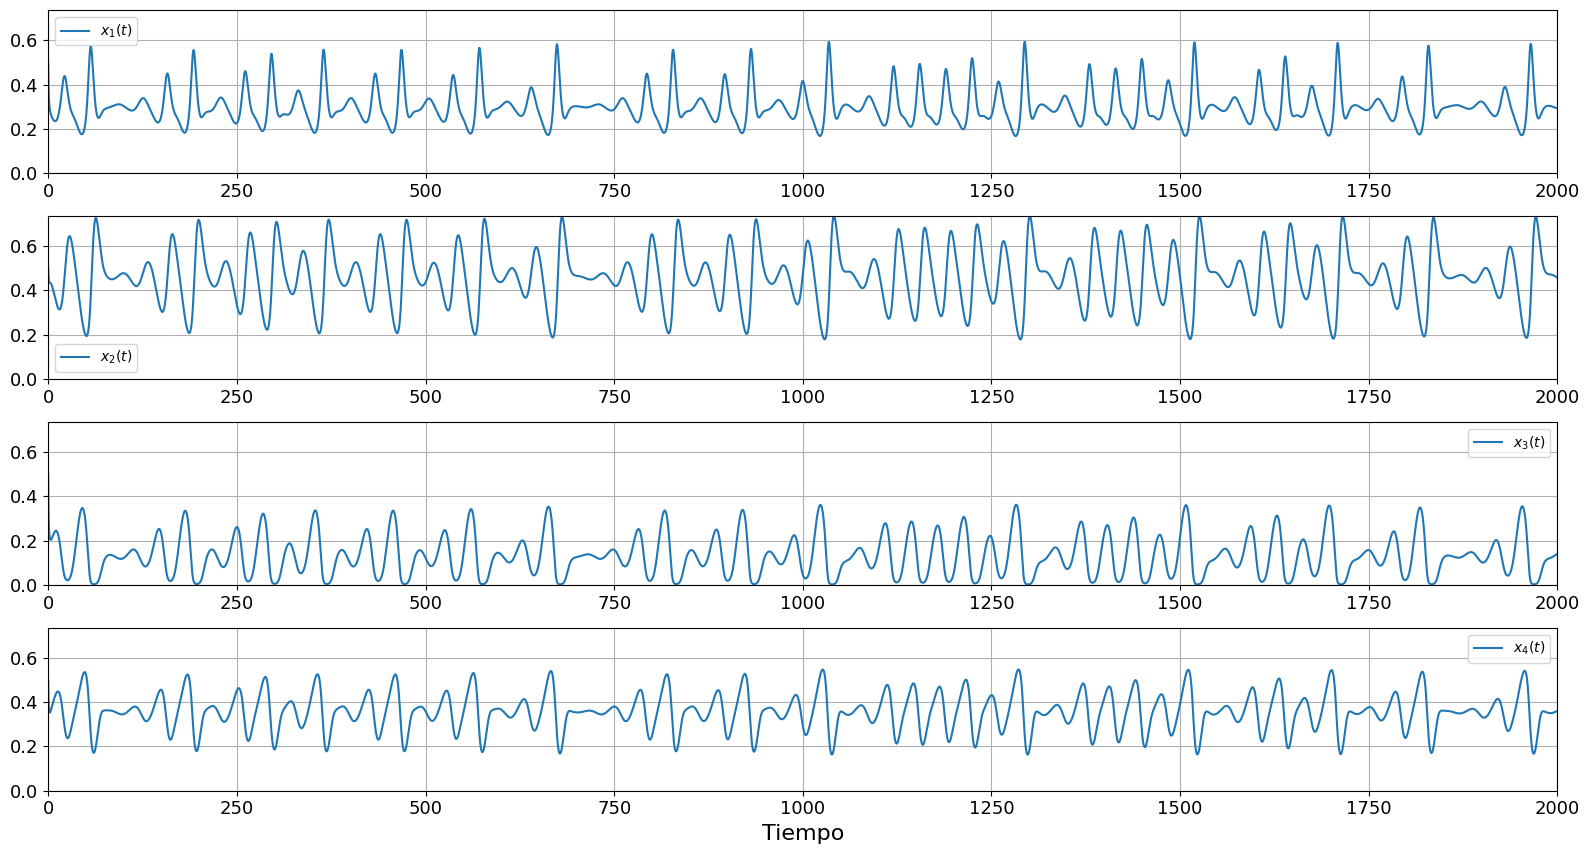

In [14]:
# %matplotlib notebook

# creamos la gráfica
fig, ax = plt.subplots(4, 1, figsize=(16,9))

ax[0].plot(sim_t, sim_X[0], label=f'$x_1(t)$')
ax[1].plot(sim_t, sim_X[1], label=f'$x_2(t)$')
ax[2].plot(sim_t, sim_X[2], label=f'$x_3(t)$')
ax[3].plot(sim_t, sim_X[3], label=f'$x_4(t)$')

# Configuración del tamaño de la fuente de los números en los ejes
plt.rc('xtick', labelsize=13)  
plt.rc('ytick', labelsize=13)

# ajustamos las etiquetas y el título
max_y = sim_X.max()
for i in range(4):
    # ax[i].set_ylabel('Población')
    ax[i].set_xlim(sim_t[0], sim_t[-1])
    ax[i].set_ylim(0, max_y)
    ax[i].legend()
    ax[i].grid(True)

ax[3].set_xlabel('Tiempo', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 

# mostramos la grafica
plt.show()

# la guardamos
# fig.savefig('evol_temp_4especies.png', dpi=600)

In [5]:
# la guardamos
# fig.savefig('evol_temp_4especies.png', dpi=600)

## 3. Representación del espacio de fases

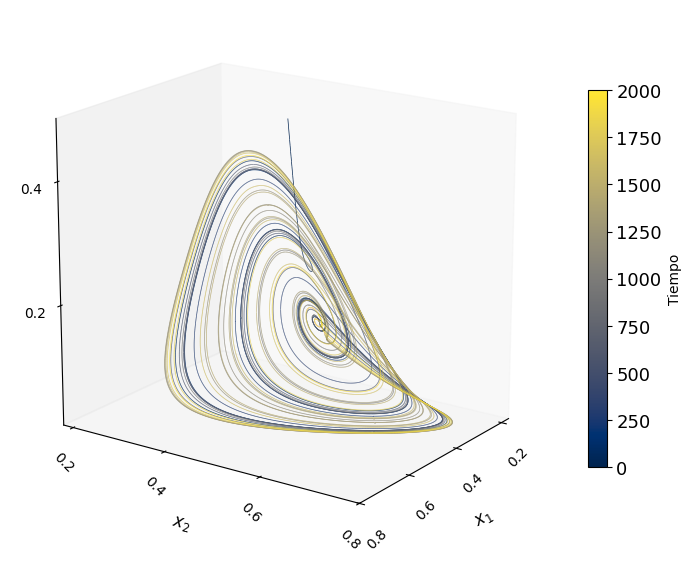

In [15]:
# %matplotlib notebook

# Creamos figura y ejes 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Asignamos color según la evolución temporal
time_sol = sim_t
c = t_span[-1] * (time_sol - time_sol.min()) / (time_sol.max() - time_sol.min())

# Creamos segmentos de línea
points = np.array([sim_X[0], sim_X[1], sim_X[2]]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Coloreamos los segmentos según 'c'
lc = Line3DCollection(segments, cmap='cividis', norm=plt.Normalize(np.min(c), np.max(c)))
lc.set_array(c)  # Define el gradiente según 'c'
lc.set_linewidth(0.5)  # Define el grosor de la línea
ax.add_collection3d(lc)

# Etiquetas de los ejes y título
ax.set_xlabel(r'$x_1$', fontsize=12, labelpad=10)
ax.set_ylabel(r'$x_2$', fontsize=12, labelpad=10)
ax.set_zlabel(r'$x_3$', fontsize=12, labelpad=10)
# ax.set_title('Espacio de fases', fontsize=14)

# Establecemos límites para que los ejes tengan proporciones iguales
xlim = [np.min(sim_X[0]), np.max(sim_X[0])]
ylim = [np.min(sim_X[1]), np.max(sim_X[1])]
zlim = [np.min(sim_X[2]), np.max(sim_X[2])]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_zlim(zlim)

# Ajustamos las marcas de los ejes
ax.set_xticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_zticks([0.2, 0.4])

# Ajustes para evitar solapamiento
ax.tick_params(axis='x', labelsize=10, rotation=45)  # Eje X
ax.tick_params(axis='y', labelsize=10, rotation=-45) # Eje Y
ax.tick_params(axis='z', labelsize=10)   

# Quitamos el grid
ax.grid(False)

# Añadimos la barra de color
cbar = plt.colorbar(lc, ax=ax, shrink=0.7)
cbar.set_label('Tiempo')

# Ajustamos proporciones de los ejes
ax.set_box_aspect([np.ptp(xlim), np.ptp(ylim), np.ptp(zlim)])  # Proporciones iguales

# Ajustamos la vista personalizada
ax.view_init(elev=18, azim=35)

# Guardamos la figura (opcional)
# fig.savefig('espacio_fasico_4especies.png', dpi=600)

plt.show()

Es interesante fijarse en la evolución temporal. Las tractorias no convergen al centro, si no que van acercándose y alejándose cíclicamente.

In [7]:
# fig.savefig('espacio_fasico_4especies.png', dpi=600)

## 4. Cálculo de los exponentes de Lyapunov
Para este sistema tenemos el siguiente Jacobiano:
$$
J_{ik}=\frac{\partial \dot x_i}{\partial x_k} = r_i\left[\left( 1-\sum_{j=1}^Na_{ij}x_j \right)\delta_{ik} -x_ia_{ik} \right].
$$

In [16]:
LCEs = model.compute_LCEs(max_iter = 100000)
print("Array de LCEs:", LCEs[0][-1])

Array de LCEs: [ 0.02862643 -1.06983991 -1.62203886 -1.7287013 ]


Podemos analizar mejor su convergencia

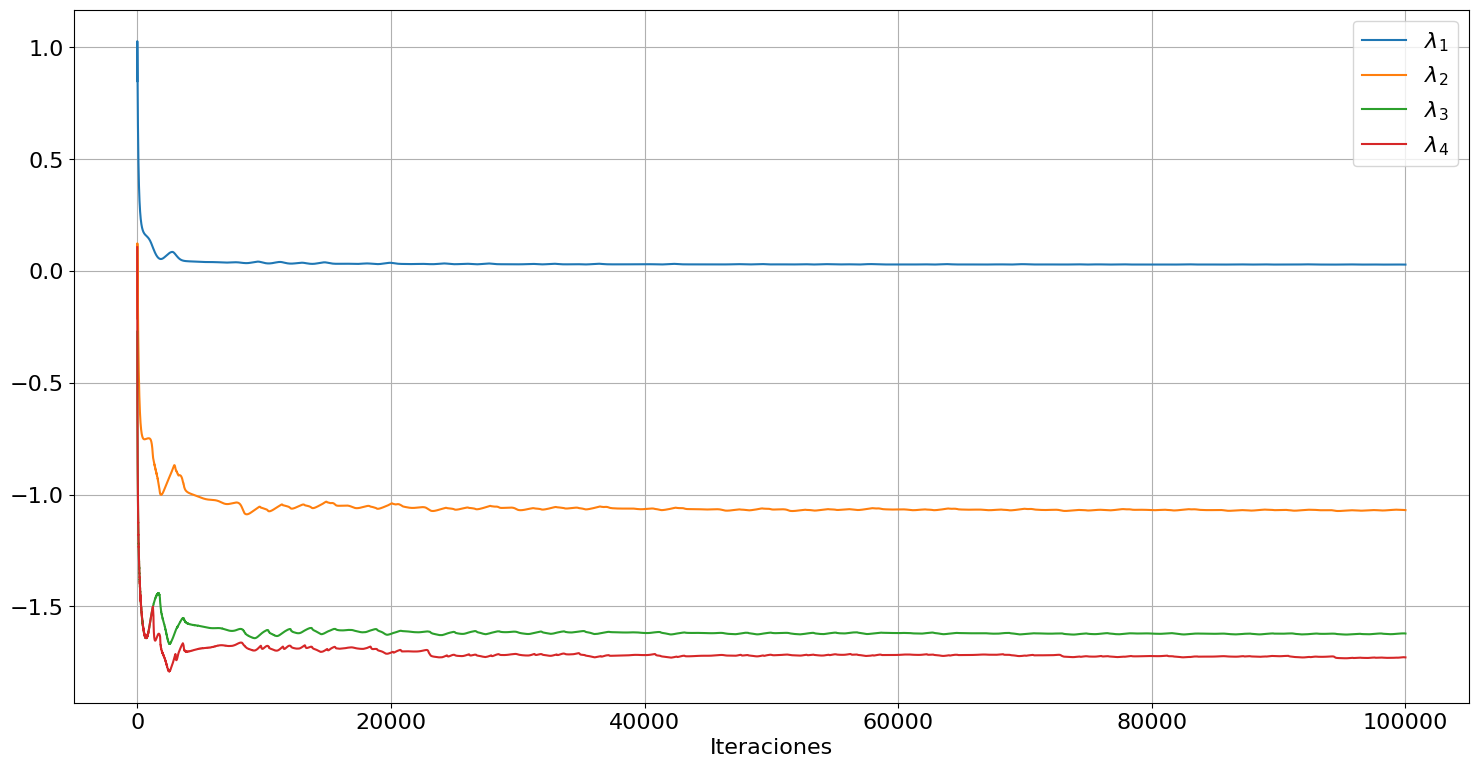

In [17]:
# Crear figura y ejes
fig_lces, ax_lces = plt.subplots(figsize=(18, 9))  

iters = np.arange(0, 100000, 1)
# Graficar los datos
plt.plot(iters, LCEs[0][:, 0], label=r'$\lambda_1$')
plt.plot(iters, LCEs[0][:, 1], label=r'$\lambda_2$')
plt.plot(iters, LCEs[0][:, 2], label=r'$\lambda_3$')
plt.plot(iters, LCEs[0][:, 3], label=r'$\lambda_4$')

# Personalizar los ejes
ax_lces.tick_params(axis='x', labelsize=16)
ax_lces.tick_params(axis='y', labelsize=16)

# Añadir leyenda, guardar y mostrar
plt.legend(fontsize=16)
plt.xlabel(r'Iteraciones', fontsize=16)
plt.grid()
# fig_lces.savefig('LCE_4especies.png', dpi=600)
plt.show()

In [10]:
# fig_lces.savefig('outputs/LCE_4especies.png', dpi=600)

Podemos hallar también su error estándar. Tendremos en cuenta solo la mitad final de los valores, que ya se puede considerar que han convergido. Primero, hallamos su desviación típica,

In [12]:
# solo tomamos la mitad final de los valores
n_mitad = len(LCEs[0][:, 0])//2
half_logs = LCEs[0][n_mitad:, :] 

# usamos la función de numpy
est = np.std(half_logs, axis = 0, ddof = 1) ## ddof = 1 porque es una muestra

print('Desviación estándar de los LCEs:', est)

Desviación estándar de los LCEs: [0.00016252 0.00170629 0.00131795 0.00207949]


## 5. Cálculo de la matriz de correlación

Necesitamos hallar los pares de coeficientes de correlación de Pearson (r). Para dos series temporales $x_1$, $x_2$, este coeficiente para una muestra es 
$$
r_{ij} = \frac{\text{Cov} (X_i,X_j)}{\sqrt{\text{Var}(X_i)\cdot\text{Var}(X_j)} }  
$$
donde 
$$
\text{Var}(X_i) = \frac{1}{n-1}\sum_{i=1}^n\left( x_i-\bar X \right)^2; \quad \text{Cov}(X, Y) = \frac1{n-1}\sum_{i=1}^n(x_i-\bar X)(y_i-\bar Y) 
$$

In [28]:
from src.functions import ccr

In [29]:
# hallamos la matriz de correlación

R_matrix= np.ones((4,4))

for i in range(4):
    for j in range(4):
        R_matrix[i,j] = ccr(sim_X[i], sim_X[j])

print('MATRIZ DE CORRELACIÓN')
print(R_matrix)

MATRIZ DE CORRELACIÓN
[[ 1.          0.112595   -0.68499372 -0.58346019]
 [ 0.112595    1.         -0.75410123 -0.86410059]
 [-0.68499372 -0.75410123  1.          0.92493331]
 [-0.58346019 -0.86410059  0.92493331  1.        ]]


## 6. Cálculo de la Correlación Total
Para la correlación total, necesitamos conocer la entropía (de información, Shannon) y la entropía conjunta. Se pueden calcular como
$$
H(X) := -\sum p(x)\log p(x);\quad H(X_1, X_2, X_3, X_4) = \sum_{x_1}\sum_{x_2}\sum_{x_3}\sum_{x_4} p(x_1, x_2, x_3, x_4)\log p(x_1, x_2, x_3, x_4).
$$

Con esto, la correlación total se calcula como
$$
TC(X_1, X_2, X_3, X_4) = \left( \sum_{i=1}^n H(X_i)\right) - H (X_1, X_2, X_3, X_4)
$$


In [30]:
from src.functions import entropy

In [31]:
# hallamos la entropía de cada serie
H1 = entropy(sim_X[0])
H2 = entropy(sim_X[1])
H3 = entropy(sim_X[2])
H4 = entropy(sim_X[3])

print("H1 = ", H1)
print("H2 = ", H2)
print("H3 = ", H3)
print("H4 = ", H4)


H1 =  2.0079889314470085
H2 =  2.308322838868525
H3 =  1.9929418825214809
H4 =  2.245416650228709


In [32]:
from src.functions import joint_entropy

In [33]:
# la calculamos
H_joint = joint_entropy(sim_X[0], sim_X[1], sim_X[2], sim_X[3])
print('Entropía Conjunta = ', H_joint)

Entropía Conjunta =  2.264151871519512


In [34]:
# hallamos la correlación total
TC = np.sum([H1, H2, H3, H4]) - H_joint

print('TotalCorrelation = ',TC.round(2))

TotalCorrelation =  6.29


En esencia, aunque cada población por separado tiene una cierta incertidumbre (o variabilidad), al combinarlas, se reduce drásticamente la incertidumbre total. Esto indica que las poblaciones no actúan de manera independiente, sino que comparten una gran parte de la información. En otras palabras, el estado o comportamiento de una población refleja en gran medida el de las otras, lo cual puede sugerir la presencia de factores comunes o interacciones fuertes entre ellas.

Esta fuerte dependencia implica que, a efectos de análisis o modelado, podría no ser necesario considerar cada población de forma aislada, ya que muchas de sus variaciones son redundantes.

## 7. Estudio de la correlación temporal
